## Przygotowanie sesji Spark
Zainicjowanie sesji Spark oraz stworzenie schematu bazy danych z której będziemy korzystać.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

Pobranie sesji Spark jest proste dla programisty korzystającego z notatnika, wymaga podania tylko kilku parametrów, ale faktyczna konfiguracja jest bardziej rozbudowana

In [2]:
import os
args = os.environ['PYSPARK_SUBMIT_ARGS'].replace("  ", "\n")
print(args)

--repositories https://oss.sonatype.org/content/repositories/snapshots/
 --jars /tmp/gcs-connector-hadoop2-1.9.17-shaded.jar,/tmp/google-cloud-nio-0.120.0-alpha-shaded.jar
 --conf spark.hadoop.google.cloud.auth.service.account.enable=true
 --conf spark.hadoop.google.cloud.auth.service.account.json.keyfile=/tmp/secrets/ds-lab-sa.json
 --conf spark.kubernetes.driverEnv.GCS_PROJECT_ID=studiapodyplomowe
 --conf spark.kubernetes.driverEnv.GOOGLE_APPLICATION_CREDENTIALS=/tmp/secrets/ds-lab-sa.json
 --conf spark.executorEnv.GCS_PROJECT_ID=studiapodyplomowe
 --conf spark.executorEnv.GOOGLE_APPLICATION_CREDENTIALS=/tmp/secrets/ds-lab-sa.json
 --conf spark.kubernetes.driver.secrets.ds-lab-sa-secret=/tmp/secrets
 --conf spark.kubernetes.executor.secrets.ds-lab-sa-secret=/tmp/secrets
 --conf spark.hadoop.fs.gs.project.id=studiapodyplomowe
 --conf spark.hadoop.fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem
 --conf spark.hadoop.fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.

Mamy pobraną sesję sparkową. Powstały dodatkowe pody gotowe na realizację obliczeń. A jak zwolnić te zasoby?

In [ ]:
spark.stop()

Ponownie pobieramy sesję Spark. Będziemy z niej korzystać. Po zakończonej pracy należy pamiętać o zastopowaniu sesji.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

## Odczyt danych
Korzystając z sesji Spark można odczytać dane zapisane w lokalizacji dostępnej dla executorów (procesów obliczeniowych) koordynowanych przez Spark. 
Konieczne jest podanie ścieżki dostępowej do pliku i formatu danych (nie jest to jednoznazne z rozszerzeniem pliku).
Dystrybucja Spark udostępnia kilka tzw Data Sources, które odczytują i zapisują dane w określonych formatach (CSV, formaty kolumnowe: parquet/orc).
Data Sources zgodne z opracowanym interfejsem można samodzielnie tworzyć. Na dzisiejszych zajęciach będziemy korzystać z takich zdefiniowanych DS:
* FASTQDataSource
* BAMDataSource
* VCFDataSource

*UWAGA - powyższe sposoby odczytu plików nie są częścią głównej dystrybucji Spark. Wymagana jest dodatkowa konfiguracja.*

In [3]:
import os                               # moduł OS języka Python
user_name = os.environ.get('USER')      # pobieramy zmienną środowiskową USER
bucket = f"gs://edugen-lab-{user_name}" # konstruujemy sciezke dostepowa do pliku
print(bucket)

gs://edugen-lab-tgambin


---

`Co oznacza f przed cudzysłowem?`

`Czy jest różnica między stosowaniem apostrofu i cudzysłowu przy definicji zmiennych przechowywujących łańcuchy znaków?`

In [4]:
reads_path = f"{bucket}/fastq/*"  # * oznacza wszystkie pliki we wskazanej lokalizacji. Można podać konkretny plik
fastq_all = spark.read.load(reads_path, format="org.biodatageeks.sequila.datasources.FASTQ.FASTQDataSource")

### Weryfikacja danych

In [5]:
type(fastq_all)      # jaki jest typ danych utworzonej zmiennej? 

pyspark.sql.dataframe.DataFrame

In [6]:
fastq_all.printSchema() # jaki jest schemat danych?

root
 |-- sample_id: string (nullable = true)
 |-- instrument_name: string (nullable = true)
 |-- run_id: integer (nullable = false)
 |-- flowcell_id: string (nullable = true)
 |-- lane: integer (nullable = false)
 |-- tile: integer (nullable = false)
 |-- pos_x: integer (nullable = false)
 |-- pos_y: integer (nullable = false)
 |-- filter_passed: boolean (nullable = false)
 |-- control_num: integer (nullable = false)
 |-- index_seq: string (nullable = true)
 |-- seq: string (nullable = true)
 |-- qual: string (nullable = true)



In [7]:
len(fastq_all.columns)           # wymiary (liczba kolumn)

13

In [8]:
fastq_all.count()

241114

In [9]:
fastq_all.explain(True)              # fizyczny plan wykonania

== Parsed Logical Plan ==
Relation[sample_id#26,instrument_name#27,run_id#28,flowcell_id#29,lane#30,tile#31,pos_x#32,pos_y#33,filter_passed#34,control_num#35,index_seq#36,seq#37,qual#38] org.biodatageeks.sequila.datasources.FASTQ.SequencedFragmentRelation@4163edb8

== Analyzed Logical Plan ==
sample_id: string, instrument_name: string, run_id: int, flowcell_id: string, lane: int, tile: int, pos_x: int, pos_y: int, filter_passed: boolean, control_num: int, index_seq: string, seq: string, qual: string
Relation[sample_id#26,instrument_name#27,run_id#28,flowcell_id#29,lane#30,tile#31,pos_x#32,pos_y#33,filter_passed#34,control_num#35,index_seq#36,seq#37,qual#38] org.biodatageeks.sequila.datasources.FASTQ.SequencedFragmentRelation@4163edb8

== Optimized Logical Plan ==
Relation[sample_id#26,instrument_name#27,run_id#28,flowcell_id#29,lane#30,tile#31,pos_x#32,pos_y#33,filter_passed#34,control_num#35,index_seq#36,seq#37,qual#38] org.biodatageeks.sequila.datasources.FASTQ.SequencedFragmentRelat

DataFrame jest abstrakcją nad innym typem danych (RDD), który jest podstawową rozproszoną strukturą danych. Poprzez DF możemy dostać się do rdd i zweryfikować na przykład liczbę partycji danych.

In [10]:
fastq_all.rdd.getNumPartitions() # liczba partycji (bloków danych)

3

### Podgląd danych

In [11]:
fastq_all.show()

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|=>:>A?>0=:?=?>;1>...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|TTCCTGTACCTCCT

In [12]:
fastq_all.show(5)  # pierwsze 5 wierszy

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|=>:>A?>0=:?=?>;1>...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|TTCCTGTACCTCCT

In [13]:
fastq_all.show(truncate=False) # bez skracania zawartości kolumn

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|seq                                                                                                                                                    |qual                                                                                                                                                   |
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+------------------------------------------------------------------------------

## Dostęp do wybranych danych

#### Operacja projekcji (SELECT)

In [14]:
fastq_all.select("sample_id").show()

+---------+
|sample_id|
+---------+
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
+---------+
only showing top 20 rows



`Czy operacja select (sample_id) wpłynęła na fastq_all?`

In [15]:
fastq_all.printSchema()
fastq_all.show() 

root
 |-- sample_id: string (nullable = true)
 |-- instrument_name: string (nullable = true)
 |-- run_id: integer (nullable = false)
 |-- flowcell_id: string (nullable = true)
 |-- lane: integer (nullable = false)
 |-- tile: integer (nullable = false)
 |-- pos_x: integer (nullable = false)
 |-- pos_y: integer (nullable = false)
 |-- filter_passed: boolean (nullable = false)
 |-- control_num: integer (nullable = false)
 |-- index_seq: string (nullable = true)
 |-- seq: string (nullable = true)
 |-- qual: string (nullable = true)

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|      son|           nu

Jeśli chcemy zachować wynik działania transformacji (w celu późniejszego wykorzystania) trzeba wynik zachować w zmiennej.

In [16]:
fastq_sample_only = fastq_all.select("sample_id")  

In [17]:
fastq_sample_only.printSchema()
fastq_sample_only.show()

root
 |-- sample_id: string (nullable = true)

+---------+
|sample_id|
+---------+
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
|      son|
+---------+
only showing top 20 rows



In [18]:
fastq_all.select("sample_id","seq").show()

+---------+--------------------+
|sample_id|                 seq|
+---------+--------------------+
|      son|GATGCTCAAACTCCAGG...|
|      son|ATTGTGCTTAACAATGC...|
|      son|CATCTATTTAGCTGAAA...|
|      son|TTCCTGTACCTCCTTCC...|
|      son|CATACCTAGCATGGCCT...|
|      son|ACTAAATTGCCATGGTA...|
|      son|AACACAGGTGGGAATTG...|
|      son|CATGTTAAGCTGCATGT...|
|      son|CTTTAGTAATTTTCCTC...|
|      son|TAAATATTTCACAACAC...|
|      son|ATCTTTGCATTTGACAC...|
|      son|AACACCAGCCTGGCCAA...|
|      son|AACACTTCTGTAGAAAA...|
|      son|GTGAGAAAATAAACCAA...|
|      son|TATACCTGGGAATGGGG...|
|      son|AGGAAATGTCCAGCTTA...|
|      son|GAATCTAATTGTCTTGG...|
|      son|TATAGAGCCCCAACCAC...|
|      son|TTTGAGAAAACTTACAG...|
|      son|ATCTGCTACTATAAGCA...|
+---------+--------------------+
only showing top 20 rows



Powiedzmy, że interesują nas wszystkie kolumny poza qual. Jak to zrobic? Można wylistować wszystkie kolumny poza qual, ale to uciazliwe. Mozna skorzystac z operacji drop.

In [19]:
fastq_no_qual=fastq_all.drop('qual')

In [20]:
fastq_no_qual.printSchema()
fastq_no_qual.show()

root
 |-- sample_id: string (nullable = true)
 |-- instrument_name: string (nullable = true)
 |-- run_id: integer (nullable = false)
 |-- flowcell_id: string (nullable = true)
 |-- lane: integer (nullable = false)
 |-- tile: integer (nullable = false)
 |-- pos_x: integer (nullable = false)
 |-- pos_y: integer (nullable = false)
 |-- filter_passed: boolean (nullable = false)
 |-- control_num: integer (nullable = false)
 |-- index_seq: string (nullable = true)
 |-- seq: string (nullable = true)

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG..

## <span style='background:yellow'> ZADANIE  </span>

Stwórz nową ramkę danych która będzie zawierać wszystkie kolumny z fastq_all poza pos_x i pos_y. Wyświetl 10 wierszy z tej kolekcji pokazując pełną zawartość kolumn

In [21]:
fastq_cropped = fastq_all.drop('pos_x', 'pos_y')
fastq_cropped.show(10, truncate=False)

+---------+---------------+------+-----------+----+----+-------------+-----------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|filter_passed|control_num|index_seq|seq                                                                                                                                                    |qual                                                                                                                                                   |
+---------+---------------+------+-----------+----+----+-------------+-----------+---------+------------------------------------------------------------------------------------------------------------------

## Wartości unikalne
Jeśli chcemy uzyskać unikalne wartości w określonych kolumnach korzystamy z metody distinct().
Operacje na DF można łańcuchowo łączyć, zatem na wyniku działania select() można wywołać kolejne metody.

In [22]:
fastq_all.select('sample_id').distinct().show()

+---------+
|sample_id|
+---------+
|   father|
|   mother|
|      son|
+---------+



In [23]:
fastq_all.select('sample_id', 'filter_passed').distinct().show()

+---------+-------------+
|sample_id|filter_passed|
+---------+-------------+
|   mother|        false|
|      son|        false|
|   father|        false|
+---------+-------------+



In [24]:
fastq_all.count()

241114

### Filtrowanie wynikow
Nasz zbiór danych posiada odczyty z 3 próbek. Ograniczmy się do wybranych próbek.

In [25]:
fastq_mother = fastq_all.filter("sample_id = 'mother'")

`Czy już odbył się odczyt danych z fastq?`

In [26]:
fastq_mother.show()

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|   mother|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|TGGAGTTCTAAATTGTG...|==:=?>=>?>>>>>>>>...|
|   mother|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GCATGTGCAAGTATCTT...|;;<<9>>>>9>:=<=?<...|
|   mother|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GCCATTAGACGACATTT...|=<=2?<0?=;5>>?>70...|
|   mother|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|AGGCAGGACTAGTT

In [27]:
fastq_mother.select('sample_id').distinct().show()

+---------+
|sample_id|
+---------+
|   mother|
+---------+



In [28]:
fastq_mother.count()

133160

Warunki można łączyć spójnikami logicznymi. Można używać operatorów arytmetycznych, przynależności do zbioru (IN), porównania znaków (LIKE), przyrównania do wartości NULL (IS NULL i IS NOT NULL)

Przy korzystaniu z LIKE można użyć % jako oznaczenie dowolnego ciągu znaków

Pokaż odczyty spełniające warunek ze nazwa instrumentu jest pusta, run_id jest >=0 a odczyt zaczyna sie od liter GCA. Pokaz tylko kolumny z filtra oraz nazwe probki

In [29]:
fastq_mother.filter('instrument_name IS NULL and run_id>=0 and seq LIKE "GCA%"').select('sample_id', 'instrument_name', 'run_id', 'seq').show()

+---------+---------------+------+--------------------+
|sample_id|instrument_name|run_id|                 seq|
+---------+---------------+------+--------------------+
|   mother|           null|     0|GCATGTGCAAGTATCTT...|
|   mother|           null|     0|GCAGGTACTCATGTTCA...|
|   mother|           null|     0|GCACATCCTGGCCTCCT...|
|   mother|           null|     0|GCAACCTCCACCTCCTA...|
|   mother|           null|     0|GCAGAAGGTGCAAAAGC...|
|   mother|           null|     0|GCATCGAATTTTTTTTC...|
|   mother|           null|     0|GCACTTCCCTGGCCACA...|
|   mother|           null|     0|GCAGTCACCTTCCCAGC...|
|   mother|           null|     0|GCACCTCTGATGCTGGA...|
|   mother|           null|     0|GCAGAAAGCTGGGTGCA...|
|   mother|           null|     0|GCATAATAGACACTAGG...|
|   mother|           null|     0|GCAATCAATCAGATGGC...|
|   mother|           null|     0|GCAACTTCAGTAAAGTC...|
|   mother|           null|     0|GCAAACGAACACAGGAA...|
|   mother|           null|     0|GCATATCATTTCCC

In [30]:
fastq_mother.select('sample_id', 'instrument_name', 'run_id', 'seq').filter('instrument_name IS NULL and run_id>=0 and seq LIKE "GCA%"').show() # kolejnosc select i filter bez znaczenia

+---------+---------------+------+--------------------+
|sample_id|instrument_name|run_id|                 seq|
+---------+---------------+------+--------------------+
|   mother|           null|     0|GCATGTGCAAGTATCTT...|
|   mother|           null|     0|GCAGGTACTCATGTTCA...|
|   mother|           null|     0|GCACATCCTGGCCTCCT...|
|   mother|           null|     0|GCAACCTCCACCTCCTA...|
|   mother|           null|     0|GCAGAAGGTGCAAAAGC...|
|   mother|           null|     0|GCATCGAATTTTTTTTC...|
|   mother|           null|     0|GCACTTCCCTGGCCACA...|
|   mother|           null|     0|GCAGTCACCTTCCCAGC...|
|   mother|           null|     0|GCACCTCTGATGCTGGA...|
|   mother|           null|     0|GCAGAAAGCTGGGTGCA...|
|   mother|           null|     0|GCATAATAGACACTAGG...|
|   mother|           null|     0|GCAATCAATCAGATGGC...|
|   mother|           null|     0|GCAACTTCAGTAAAGTC...|
|   mother|           null|     0|GCAAACGAACACAGGAA...|
|   mother|           null|     0|GCATATCATTTCCC

## <span style='background:yellow'> ZADANIE  </span>

Napisz polecenie które policzy ile jest rekordów dla próbki syna które spełniają warunki, że sekwencja odczytu konczy się na TGG a qual zaczyna się od ==.

In [31]:
fastq_all.filter("sample_id='son' and seq LIKE '%TGG' and qual LIKE '==%' ").count()

83

## Uzywanie funkcji, kolumny wyliczane

In [32]:
fastq_all.selectExpr("*").show()

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|=>:>A?>0=:?=?>;1>...|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|TTCCTGTACCTCCT

In [33]:
fastq_all.selectExpr("*", "length(seq) as len_seq", "length(qual) as len_qual" ).show() ## dodanie dwóch kolumn wyliczanych przy uzyciu funkcji LENGTH

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+-------+--------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|len_seq|len_qual|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+-------+--------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...|    151|     151|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...|    151|     151|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|=>:>A?>0=:?=?>;1>...|    151|     151|
|      son|     

In [34]:
extended_fastq = fastq_all.selectExpr("*", "length(seq) as len_seq", "length(qual) as len_qual" )

In [35]:
from pyspark.sql.functions import current_date
extended_fastq.withColumn ("date", current_date()).show()

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+-------+--------+----------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|len_seq|len_qual|      date|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+-------+--------+----------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...|    151|     151|2021-01-15|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...|    151|     151|2021-01-15|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|

In [36]:
from pyspark.sql.functions import lit

fastq_all.withColumn("format", lit('FASTQ')).show()

+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+------+
|sample_id|instrument_name|run_id|flowcell_id|lane|tile|pos_x|pos_y|filter_passed|control_num|index_seq|                 seq|                qual|format|
+---------+---------------+------+-----------+----+----+-----+-----+-------------+-----------+---------+--------------------+--------------------+------+
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|GATGCTCAAACTCCAGG...|=>>=@==?>>=>>>?9<...| FASTQ|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|ATTGTGCTTAACAATGC...|995+7))>:,,94=,=9...| FASTQ|
|      son|           null|     0|       null|   0|   0|    0|    0|        false|          0|     null|CATCTATTTAGCTGAAA...|=>:>A?>0=:?=?>;1>...| FASTQ|
|      son|           null|     0|       null|   0|   0|    0|    0|        

## <span style='background:yellow'> ZADANIE  </span>

Napisz polecenie które zwróci ramkę danych zawierającą sklejenie wartości dwóch kolumn (sample_id) oraz daty eksperymentu (dodaj kolumne z wartościami 2019-01-15). W wynikach chcemy mieć tylko dane matki i ojca. Kolumny wynikowe: nazwa próbki, seq, qual, data eksperymentu oraz scalona nazwa probki oraz data eksperymenty (np father2019-01-15).

In [37]:
from pyspark.sql.functions import to_date, lit, concat

fastq_all.withColumn("experiment_date", to_date(lit('2019-01-15')))\
        .withColumn("sample_date", concat("sample_id", "experiment_date"))\
        .select ("sample_id", "sample_date", "seq", "qual", "experiment_date")\
        .filter ("sample_id IN ('mother', 'father')")\
        .show()

+---------+----------------+--------------------+--------------------+---------------+
|sample_id|     sample_date|                 seq|                qual|experiment_date|
+---------+----------------+--------------------+--------------------+---------------+
|   mother|mother2019-01-15|TGGAGTTCTAAATTGTG...|==:=?>=>?>>>>>>>>...|     2019-01-15|
|   mother|mother2019-01-15|GCATGTGCAAGTATCTT...|;;<<9>>>>9>:=<=?<...|     2019-01-15|
|   mother|mother2019-01-15|GCCATTAGACGACATTT...|=<=2?<0?=;5>>?>70...|     2019-01-15|
|   mother|mother2019-01-15|AGGCAGGACTAGTTCCT...|::;,::*-=0:>88-+;...|     2019-01-15|
|   mother|mother2019-01-15|ATAAGGGGGCCACTTTT...|==8=??>>>?>?>@>==...|     2019-01-15|
|   mother|mother2019-01-15|TGAAAAACCACATGGAA...|/99;;9=8=>=-2=::3...|     2019-01-15|
|   mother|mother2019-01-15|GAAATGCTTAATTACCC...|====2??@<=>>==8=0...|     2019-01-15|
|   mother|mother2019-01-15|CCACAAAAGCCTTTATC...|;;<6<.>=>2+>=8,=9...|     2019-01-15|
|   mother|mother2019-01-15|CAACTTAACAAATTC

## Grupowanie

In [38]:
fastq_all.groupBy("sample_id").show()

AttributeError: 'GroupedData' object has no attribute 'show'

In [39]:
type(fastq_all.groupBy("sample_id")) # to nie jest DF

pyspark.sql.group.GroupedData

In [40]:
sample_count=fastq_all.groupBy("sample_id").count()

In [41]:
type(sample_count)

pyspark.sql.dataframe.DataFrame

In [42]:
sample_count.show()

+---------+------+
|sample_id| count|
+---------+------+
|   father| 53770|
|   mother|133160|
|      son| 54184|
+---------+------+



In [43]:
sample_count.orderBy("count").show()

+---------+------+
|sample_id| count|
+---------+------+
|   father| 53770|
|      son| 54184|
|   mother|133160|
+---------+------+



## <span style='background:yellow'> ZADANIE  </span>

Napisz funkcje, ktora znajdzie rozklady jakosci dla 1, 2, 3 i 4 pozycji odczytu.
*Nastepnie zaprezentuj wyniki w postaci serii histogramów

<AxesSubplot:>

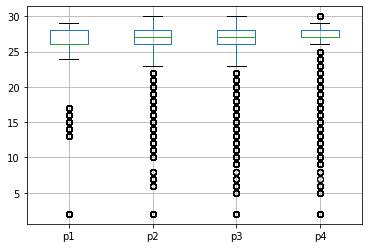

In [74]:
quals = fastq_all.selectExpr( "ascii(SUBSTR(qual,1)) -33 as p1", 
                                    "ascii(SUBSTR(qual,2))-33 as p2",
                                    "ascii(SUBSTR(qual,3))-33 as p3",
                                    "ascii(SUBSTR(qual,4))-33 as p4")


import matplotlib.pyplot as plt
quals.toPandas().boxplot()

### Mapowanie do genomu referencyjnego
Wykonamy mapowanie do genomu referencyjnych korzystając z rozproszenia danych miedzy procesy obliczeniowe sparka.

Przygotowanie ścieżek do plików.

In [44]:
import os
user_name = os.environ.get('USER')
bucket = f"gs://edugen-lab-{user_name}"

reads_file_path = f"{bucket}/fastq/mother.fastq"
ref_path = "/mnt/data/mapping/ref/ref.fasta"

Konstruujemy komendę, która będzie uruchamiana na procesach obliczeniowych. Potrzebne narzędzia muszą być dostępne na węzłach obliczeniowych.

In [45]:
command = f'bwa mem -p {ref_path} - | samtools fixmate -m - - | samtools sort  | samtools markdup -r -S - -  | samtools addreplacerg  -r "ID:S1" -r "SM:S1"  -r "PL:ILLUMINA" - | samtools view -b -'

Żeby wykonać rozproszone obliczenia na danych genomicznych nalezy wykorzystac dodatkową bibliotekę.

In [46]:
from pyseqtender import SeqTenderAlignment

seq_aligner = SeqTenderAlignment(spark, reads_file_path, command)
alignments_rdd = seq_aligner.pipe_reads()

Zapisujemy plik na kubełek.

In [47]:
bam_file_path = f"{bucket}/bam/mother10.bam"
seq_aligner.save_reads(bam_file_path, alignments_rdd)

In [48]:
!gsutil ls gs://edugen-lab-$USER/bam

gs://edugen-lab-tgambin/bam/
gs://edugen-lab-tgambin/bam/mother10.bam
gs://edugen-lab-tgambin/bam/mother10.bam.bai
gs://edugen-lab-tgambin/bam/mother10.bam.sbi


## <span style='background:yellow'> ZADANIE  </span>

Na podstawie notatników z zajęć z genomiki wyświetl fragment pliku BAM w widge'cie IGV. 

In [58]:
# najpierw trzeba upublicznić kubełek
!gsutil iam ch allUsers:objectViewer $bucket

from igv_jupyterlab import IGV
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)
t1 = igv.create_track(
        name = "mother BAM",
        url = f"{bucket}/bam/mother10.bam",
        index_url= f"{bucket}/bam/mother10.bam.bai",
        indexed= True
)

igv.load_track(t1)

igv.search_locus("20", 10002294, 10002623)

No changes made to gs://edugen-lab-tgambin/


IGV(id='igv_1409546', initialConfig={'id': 'igv_1409546', 'locus': '', 'genome': 'hg19'})

Kończymy notatniki, należy zamknąć sesję.

In [ ]:
spark.stop()